In [3]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px

st.set_page_config(
    page_title="Life Expectancy Dashboard",
    page_icon="bar_chart:",
    layout='wide')
st.title("Dashboard and Summary")
st.write(''' Welcome To Life Expectancy Dashboard Dashboard''')

def main():
    # Load your dataset
    try:
        data_url="life expectancy.csv"
        df = pd.read_csv(data_url)

        # Display the DataFrame
        st.subheader("Data Preview:")
        st.dataframe(df)

        # Add blocks for average values
        add_average_blocks(df)

        # Add visualizations
        create_visualizations(df)
    except pd.errors.EmptyDataError:
        st.error("Error: Empty dataset.")
    except Exception as e:
        st.error(f"Error: {e}")
        
def add_average_blocks(df):
    st.sidebar.subheader("Average Values of India:")
    
    # Average Life Expectancy of India
    india_avg_life_expectancy = df[df['Country Name'] == 'India']['Life Expectancy World Bank'].mean()
    st.sidebar.write(f"Avg. Life Expectancy of India: {india_avg_life_expectancy:.2f} years")

    # Average CO2 Emissions of India
    india_avg_co2_emissions = df[df['Country Name'] == 'India']['CO2'].mean()
    st.sidebar.write(f"Avg. CO2 Emissions of India: {india_avg_co2_emissions:.2f} metric tons per capita")

    # Average Health Expenditure % of India
    india_avg_health_expenditure = df[df['Country Name'] == 'India']['Health Expenditure %'].mean()
    st.sidebar.write(f"Avg. Health Expenditure % of India: {india_avg_health_expenditure:.2f}%")

    # Average Education Expenditure % of India
    india_avg_education_expenditure = df[df['Country Name'] == 'India']['Education Expenditure %'].mean()
    st.sidebar.write(f"Avg. Education Expenditure % of India: {india_avg_education_expenditure:.2f}%")

def create_visualizations(df):
    # Sidebar for multifilter slicer
    st.sidebar.subheader("Filter Data:")

    # Get unique values for regions and income groups
    all_regions = df['Region'].unique()
    all_income_groups = df['IncomeGroup'].unique()

    # Default selection includes all values
    selected_regions = st.sidebar.multiselect("Select Regions", all_regions, default=all_regions)
    selected_income_groups = st.sidebar.multiselect("Select Income Groups", all_income_groups, default=all_income_groups)

    # Create year slicer
    selected_years = st.sidebar.slider("Select Year Range", min_value=2001, max_value=2019, value=(2001, 2019), step=1)

    # Filter data based on slicer selections
    filtered_data = df[
        (df['Region'].isin(selected_regions)) &
        (df['IncomeGroup'].isin(selected_income_groups)) &
        (df['Year'].between(selected_years[0], selected_years[1]))
    ]
    # Visualizations
    st.subheader("Visualizations:")

    # Graph 1: Bar Plot - Region-wise Unemployment
    st.subheader("Graph 1: Region-wise Unemployment")
    region_unemployment = filtered_data.groupby("Region")["Unemployment"].mean()
    st.bar_chart(region_unemployment)

    # Graph 2: Bar Plot - Region-wise Life Expectancy and Line Plot - Prevalence of Undernourishment
    st.subheader("Graph 2: Region-wise Life Expectancy and Prevalence of Undernourishment")
    fig, ax1 = plt.subplots(figsize=(10, 6))
    df1 = filtered_data.groupby("Region")[["Life Expectancy World Bank", "Prevelance of Undernourishment"]].mean().reset_index()
    ax1.bar(df1['Region'], df1['Life Expectancy World Bank'], color='blue', alpha=0.7, label='Life Expectancy')
    ax1.set_xlabel('Region')
    ax1.set_ylabel('Life Expectancy', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.plot(df1['Region'], df1['Prevelance of Undernourishment'], color='red', marker='o', label='Prevalence of Undernourishment')
    ax2.set_ylabel('Prevalence of Undernourishment', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    st.pyplot(fig)

    # Graph3: Scatter Plot - Relationship between CO2 Emissions and Life Expectancy
    st.subheader("Graph 3: Scatter Plot: Relationship between CO2 Emissions and Life Expectancy")

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(filtered_data['CO2'], filtered_data['Life Expectancy World Bank'], alpha=0.7)
    ax.set_xlabel('Carbon Dioxide Emissions (kiloton)')
    ax.set_ylabel('Life Expectancy')
    ax.set_title('Relationship between CO2 Emissions and Life Expectancy')
    # Add hover information using ax.text
   
    # Show Plotly figure in Streamlit
    st.plotly_chart(fig)



    # Graph 4: Scatter Plot - Impact of Expenditure on Health and Education on Life Expectancy
    st.subheader("Graph 4: Impact of Expenditure on Life Expectancy")
    fig, ax = plt.subplots(figsize=(10, 6))
    # Group by 'Year Range' and calculate the mean for each group
    grouped = filtered_data.groupby("Country Name").agg({
        'Health Expenditure %': 'mean',
        'Education Expenditure %':'mean',
        'Life Expectancy World Bank': 'mean'
    }).reset_index()
    scatter = ax.scatter(grouped['Health Expenditure %'], grouped['Life Expectancy World Bank'], c=grouped['Education Expenditure %'], cmap='viridis', alpha=0.7)
    ax.set_xlabel('Health Expenditure %')
    ax.set_ylabel('Life Expectancy World Bank')
    ax.set_title('Impact of Expenditure on Life Expectancy')
    ax.legend(*scatter.legend_elements(), title='Education Expenditure %')
    st.plotly_chart(fig)

    # Graph 5: Pie Plot - Region-wise Corruption
    st.subheader("Graph 5: Region-wise Corruption")

    # Create a copy of the filtered data to avoid modifying the original DataFrame
    filtered_data_copy = filtered_data.copy()

    # Convert 'Corruption' column to numeric (in case it's not already)
    filtered_data_copy['Corruption'] = pd.to_numeric(filtered_data_copy['Corruption'], errors='coerce')

    # Drop rows with missing values in 'Corruption' column
    filtered_data_copy = filtered_data_copy.dropna(subset=['Corruption'])

    # Create the pie plot using matplotlib
    fig, ax = plt.subplots(figsize=(8, 8))
    region_corruption = filtered_data_copy.groupby("Region")["Corruption"].mean()
    ax.pie(region_corruption, labels=region_corruption.index, autopct='%1.1f%%', startangle=90)
    ax.set_title('Region-wise Corruption')

    # Display the plot using Streamlit
    st.pyplot(fig)


    # Graph 6: Line Plot - Income Group-wise Life Expectancy
    st.subheader("Graph 6: Income Group-wise Life Expectancy World Bank")
    fig, ax = plt.subplots(figsize=(10, 6))
    income_group_education = filtered_data.groupby("IncomeGroup")["Life Expectancy World Bank"].mean()
    ax.plot(income_group_education.index, income_group_education.values, marker='o', linestyle='-', color='purple')
    ax.set_xlabel('Income Group')
    ax.set_ylabel('Life Expectancy World Bank %')
    ax.set_title('Income Group-wise Life Expectancy World Bank')
    st.plotly_chart(fig)

    # Graph 7: Multiline Plot - Effect of Communicable and Non-Communicable Diseases on Life Expectancy (Grouped by Year)
    st.subheader("Graph 7 : Multiline Plot: Effect of Communicable and Non-Communicable Diseases on Life Expectancy (Grouped by Year)")
    fig, ax = plt.subplots(figsize=(12, 8))

    # Group by 'Year' and calculate the mean for each group
    grouped_data = filtered_data.groupby("Year").agg({
        'Communicable': 'mean',
        'NonCommunicable': 'mean',
        'Life Expectancy World Bank': 'mean'
    }).reset_index()

    # Plot the mean values
    ax.plot(grouped_data['Communicable'], grouped_data['Life Expectancy World Bank'],marker='o', label='Communicable Diseases')
    ax.plot(grouped_data['NonCommunicable'],grouped_data['Life Expectancy World Bank'],marker='o', label='Non-Communicable Diseases')
    ax.set_ylabel('Life Expectancy')
    ax.set_title('Effect of Communicable and Non-Communicable Diseases on Life Expectancy (Grouped by Year)')
    ax.legend()
    st.pyplot(fig)

if __name__ == "__main__":
    main()

C:\Users\Hritika\anaconda3\Lib\site-packages\plotly\matplotlylib\renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



# Brief on the data #

The data for this analysis was sourced from the World Bank Open Data and Our World in Data, covering 174 countries for the years 2000-2019. Key variables include health and education expenditure (% of GDP), prevalence of undernourishment, communicable disease DALYs, corruption (CPIA rating), unemployment rate, carbon dioxide emissions, and life expectancy.

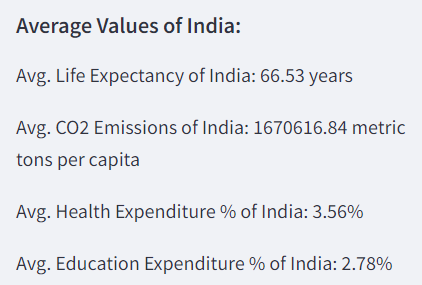

## These are the values of India : ##

Avg. Life Expectancy of India: 66.53 years

Avg. CO2 Emissions of India: 1670616.84 metric tons per capita

Avg. Health Expenditure % of India: 3.56%

Avg. Education Expenditure % of India: 2.78% 2.78%

## Slicer on the basis of Regions, Income Group and years ##

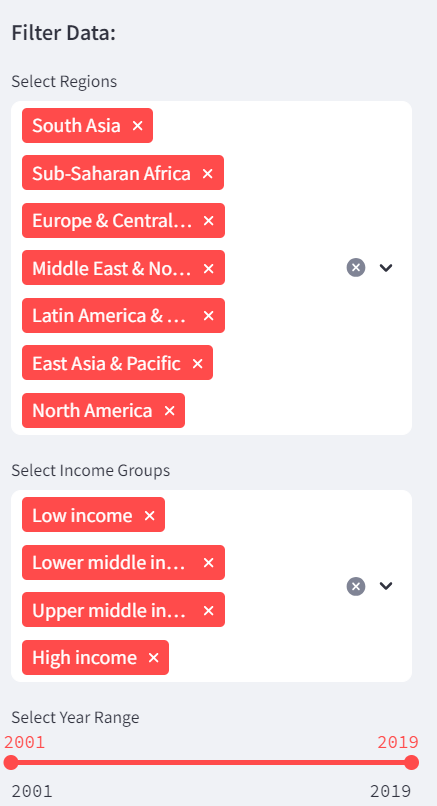

# Objective #

1. Evaluate and compare unemployment rates across different regions to identify regions with higher or lower unemployment rates.
2. Assess the regional disparities in employment opportunities and potential implications for policy interventions.
3. Examine the relationship between life expectancy and the prevalence of undernourishment across different regions.
4. Identify regions where undernourishment is more prominent and assess its potential impact on life expectancy.
5. Assess whether there is a discernible pattern or correlation between increased CO2 emissions and changes in life expectancy. 
6. Analyze the correlation between health and education expenditure (% of GDP) and life expectancy.
7. Identify countries that exhibit higher life expectancy with increased expenditure on health and education. 
8. Provide a visual breakdown of corruption levels across different regions.
9. Explore the relationship between income groups and education expenditure (% of GDP).
10. Assess whether higher-income groups allocate a larger percentage of their GDP to education.   
11. Illustrate the combined impact of communicable and non- communicable diseases on life expectancy.


# Observations (on the basis of graphs) #

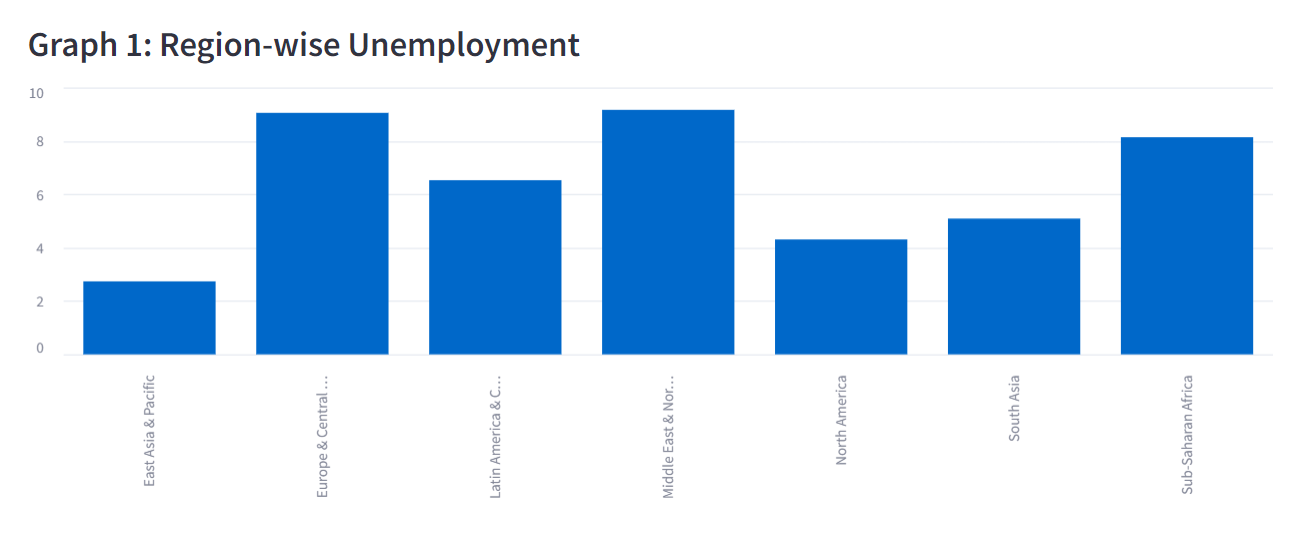

Graph 1: Region-wise Unemployment :

      1.1 North and East Norway has the highest unemployment rate,(9.166), indicating potential economic challenges.
      
      1.2 East Asia and pacific has lowest unemployment rate(2.733), suggesting strong economic stability.
      
      1.3 out of all region South Asia, under which india lie has the unemployment rate of 5.088.
      
      1.4 East Asia and Pacific, South Asia, and North America stand out as regions with relatively favorable unemployment rates. 

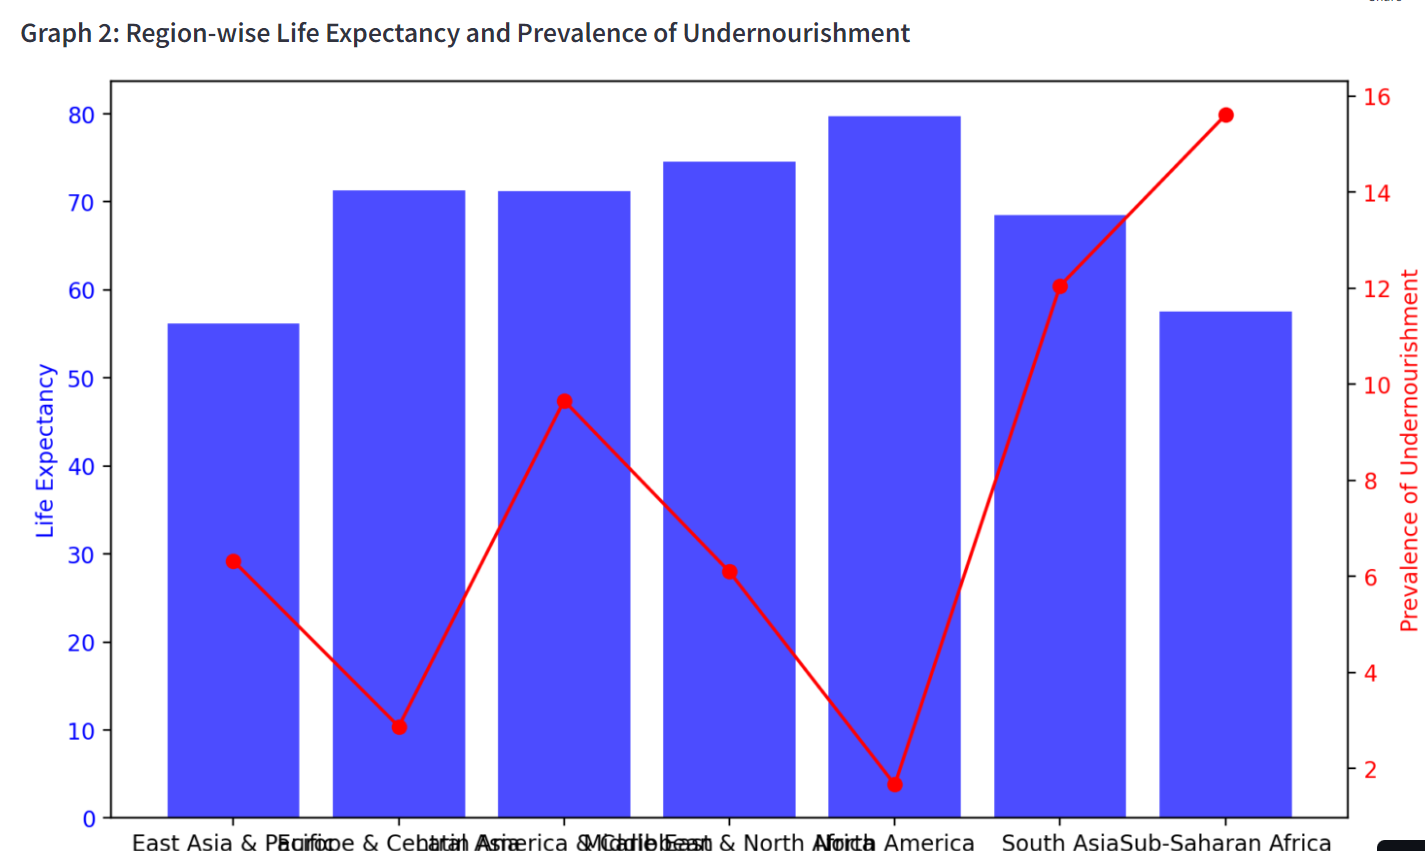

Graph 2: Region-wise Life Expectancy and Prevalence of Undernourishment :

      1.1 North America has the highest Life Expectancy and lowest prevalance of undernourishment.
      
      1.2 Sub-Saharan-Africa has the lowest life expectancy rate and highest prevalance of undernourishment,underscores the urgent need for interventions in healthcare and nutrition.
      
      1.3 Europe & Central Asia, Middle East & North Africa has the better life expectancy with low prevalance of undernourishment.
      
      1.4 Latin america has good level of life expectancy by with high level of High prevalancy of undernourishment

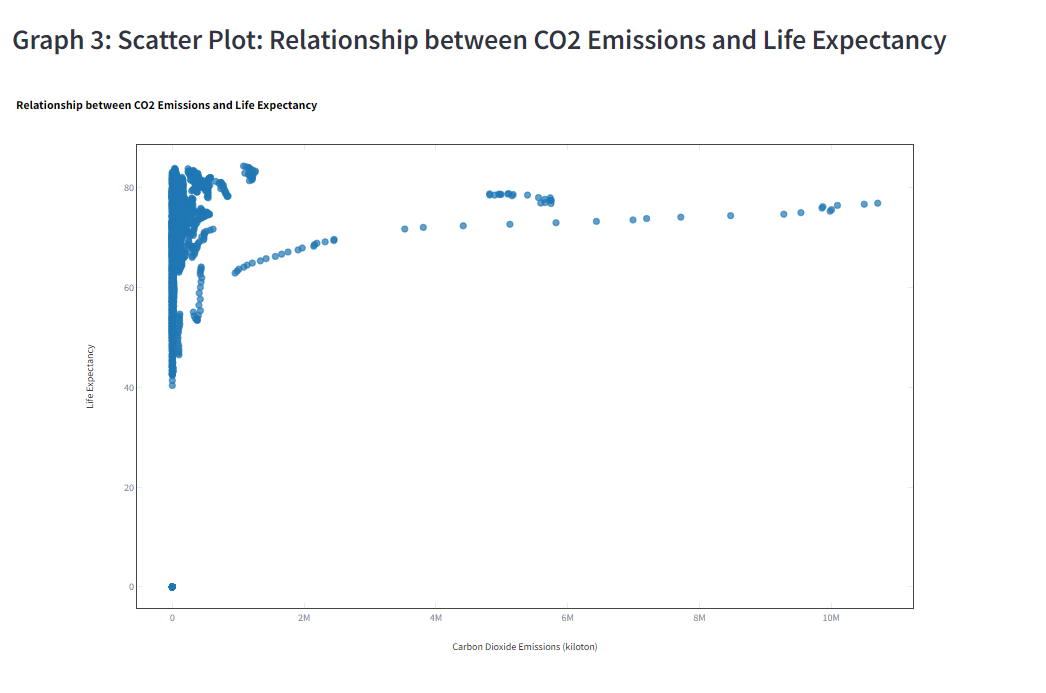

Graph 3: CO2 Emissions vs Life Expectancy :

      1.1 When there is CO2 emissions between 0 to 0.2 *e^7, maximum times high expectancy i.e, betwwn 60 to 80 years, only some have betwwn 40 to 60.
      
      1.2 when co2 emissions increases, life expectancy is around 60 years.           

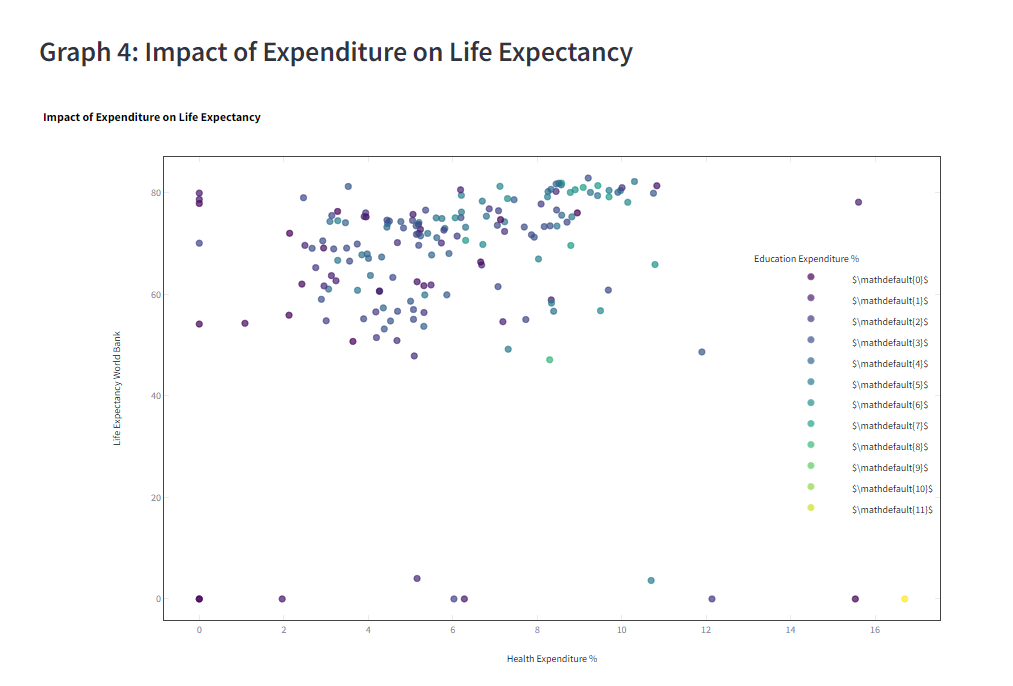

Graph 4: Impact of Expenditure on Life Expectancy (on grouping year wise)

      1.1 when health expenditure and education expenditure are very low, life expectancy is also very low.
      
      1.2 some countries have exception, as can be seen, country with low health and education expenditure have high life expectancy, 
          whereas country with both highest has low life expectancy.
          
      1.3 Approximately, 7-9 % of GDP contribution toward Education and 4 - 12 % of GDP toward health considerd good for average life expectancy, 
          with some exception. It depends from country to country based on different condition.

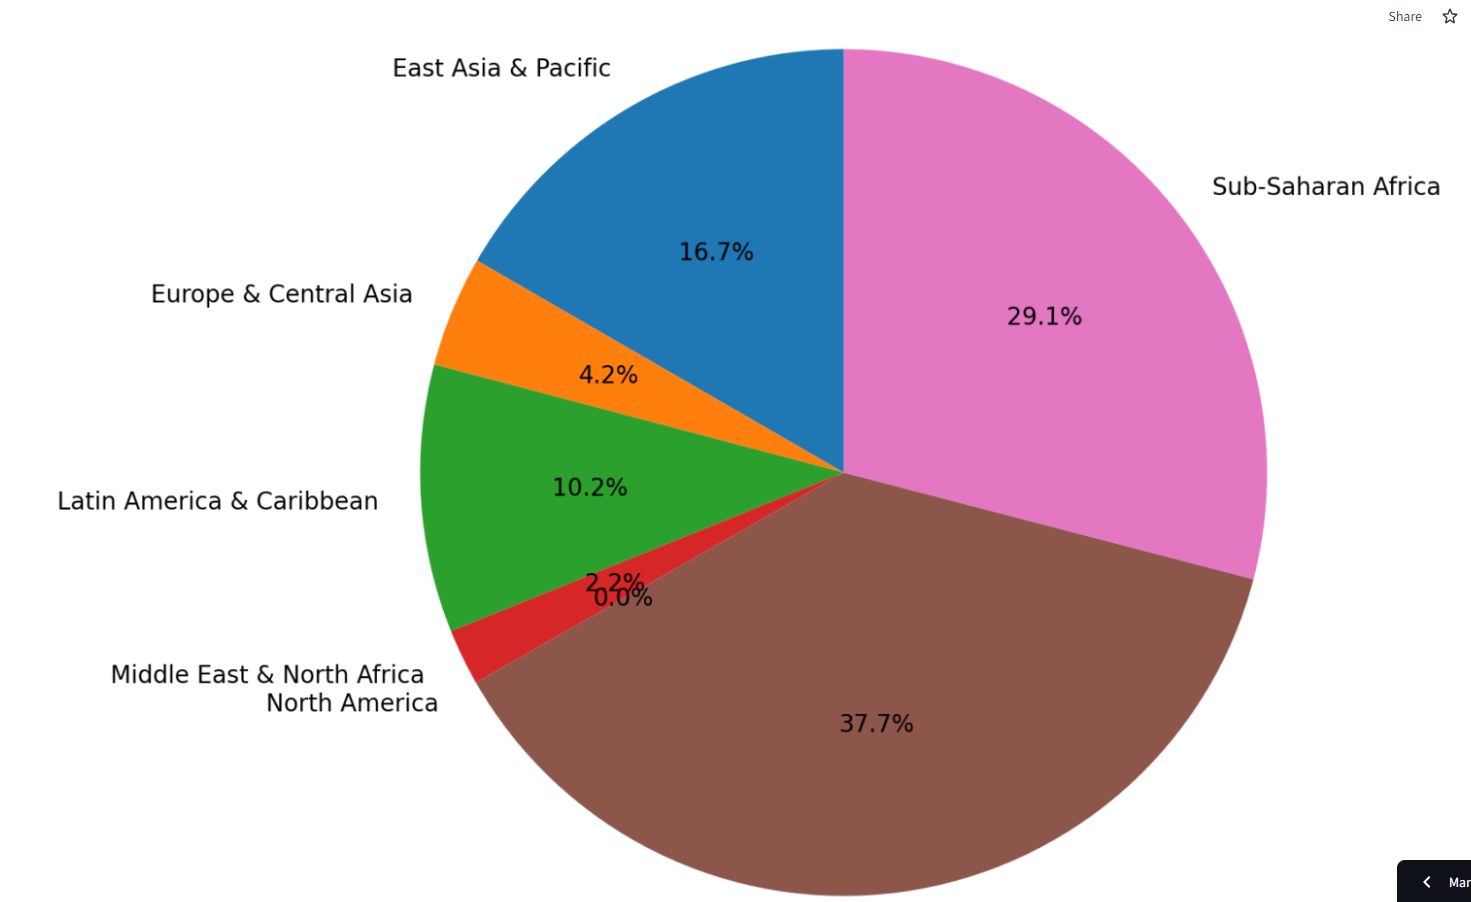

Graph 5: Region-wise Corruption:

      1.1 Over the years, North America has the zero corruption
      
      1.2 South Asia has the highest corruption.
      
      1.3 Sub Saharan africa has the second largest corruption. Combating undernourishment is crucial for improving life expectancy, especially in    regions like Sub-Saharan Africa.
      
      1.4 Middle East & North Africa has only 2.2% corruption comparitive to others.

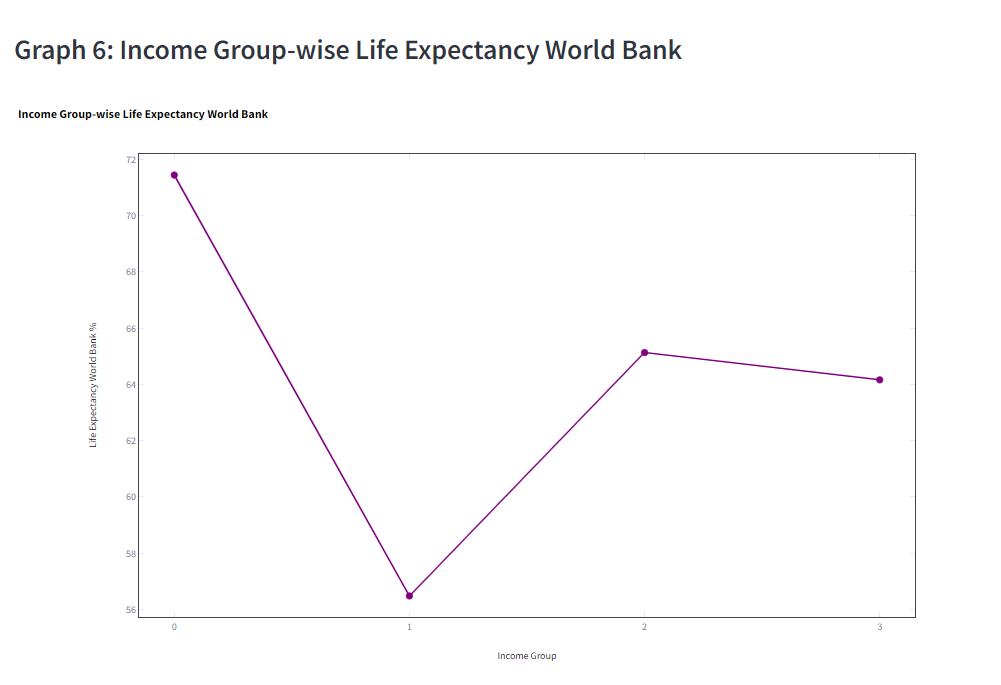

Graph 6: Income Group-wise Life Expectancy World Bank

      1.1 High income countries has high average lifespan  of 70-72
      
      1.2 Low income countries have lowest average lifespan of 56-58
      
      1.3 Upper middle income and Lower middle income has average lifespan of around 62-66
      

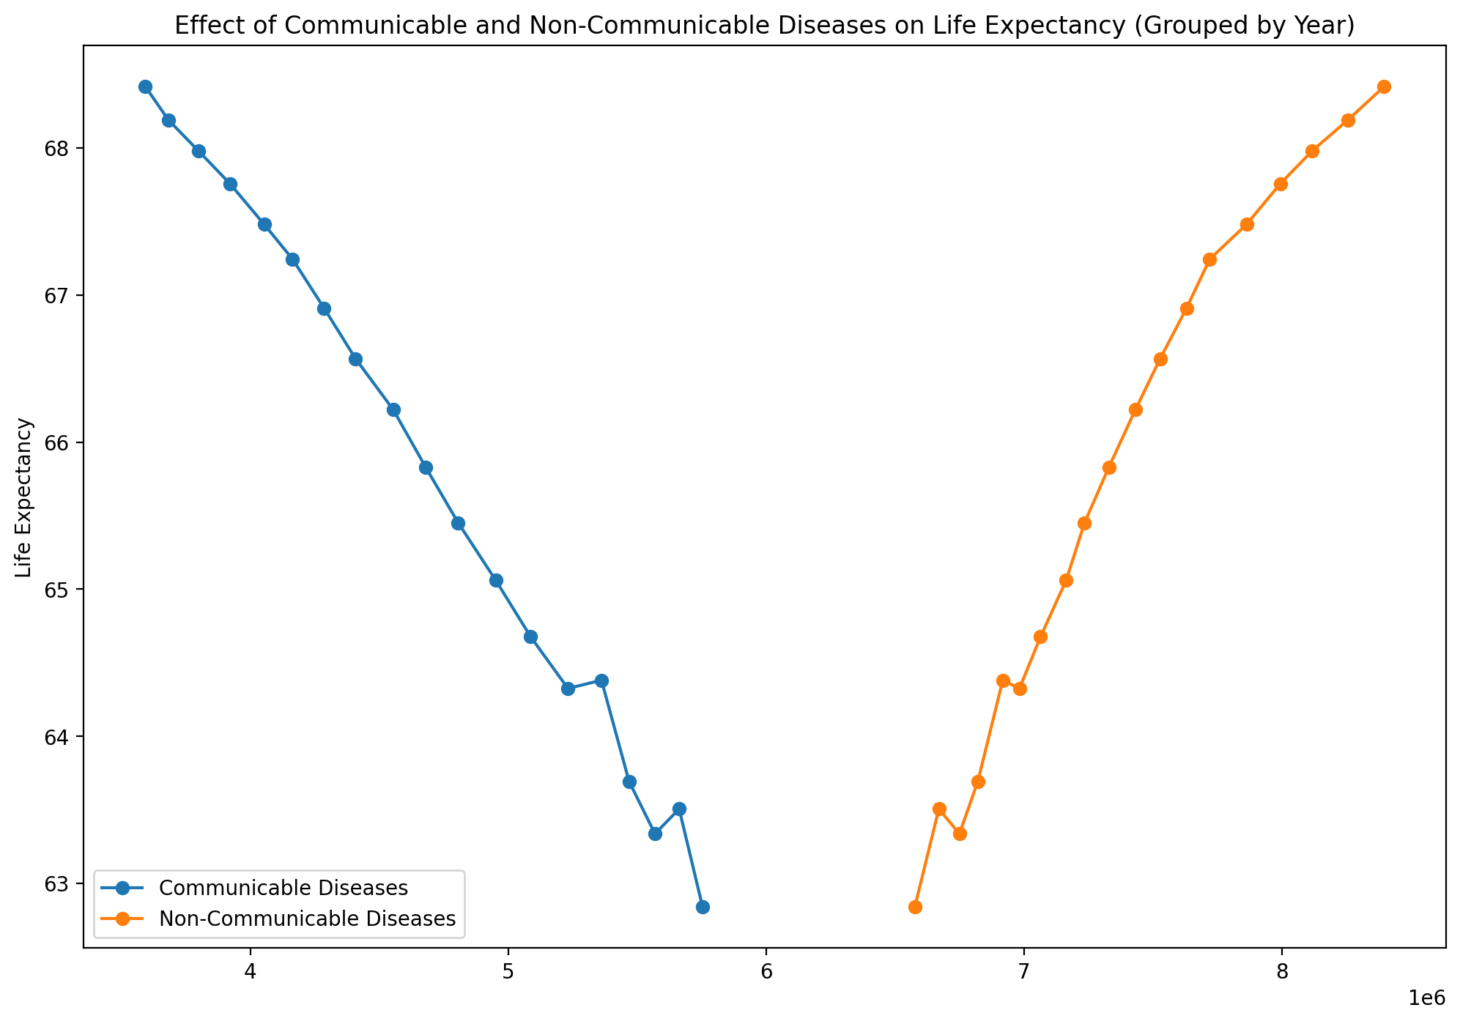

Graph 7 :
      1.1 Communicable Disease increase corresponds with an decrease in life expectancy, importance of disease prevention 
and control measures.
          
      1.2 Non-Communicable Disease Increae sllightly associated with a rise in life expectancy, highlighting the need for comprehensive healthcare   strategies addressing various health conditions. 

# Managerial Implications #

If we decrease CO2 emissions, unemployment rate, it automaticalyy give rise to Life Expectancy.

1. Governments in regions with high unemployment should initiate targeted investment in key sectors, such as infrastructure, technology, and renewable energy. Offer tax incentives to businesses for job creation, invest in vocational training programs, and establish public-private partnerships to stimulate economic growth.
   
2. Collaborative platforms for global policy exploration enable countries to learn from each other's successes, fostering a cross-cultural exchange of effective employment strategies. Policymakers globally should create forums for sharing successful employment policies and exploring adaptability. Establish international conferences, webinars, and collaborative platforms where countries can exchange insights on effective employment strategies and adapt them to their local contexts.                                                                                                                                                         
3. Policymakers can conduct in-depth studies on successful employment strategies in East Asia and Pacific and North America. Establish research committees, engage in knowledge-sharing initiatives, and conduct cross-regional policy dialogues to formulate effective employment measures based on successful models.
   
4. Prioritize investments in healthcare infrastructure, training healthcare professionals, and implementing disease prevention programs. Develop partnerships with international organizations, invest in medical facilities, and conduct public health awareness campaigns to address healthcare challenges.

5. Implement comprehensive nutritional programs alongside healthcare initiatives to address specific challenges in Latin America. Establish nutritional education programs, provide access to fortified foods, and collaborate with NGOs to address food insecurity and nutritional deficiencies.
  
6. Governments should adopt and enforce policies promoting renewable energy, sustainable practices, and emissions reduction. Invest in renewable energy sources, incentivize eco-friendly practices, and set emissions reduction targets to mitigate the impact on public health.

7. Countries with low life expectancies should prioritize budget allocations for healthcare infrastructure and education. Increase funding for medical facilities, train healthcare professionals, and invest in educational programs to improve literacy and skills.
 
8. Policymakers should conduct thorough assessments of country-specific factors when setting health and education expenditure targets. Establish expert committees, conduct regular evaluations, and adapt expenditure targets based on evolving economic and social dynamics.

9. Implement training programs, codes of conduct, and ethical guidelines for public officials to foster a culture of integrity. Introduce leadership training, create whistleblower protection mechanisms, and enforce consequences for ethical violations.

10. Governments should enact and enforce laws promoting transparency, accountability, and anti-corruption measures. Strengthen anti-corruption agencies, implement e-governance solutions, and enhance public access to government information to ensure accountability.

11. Encourage international collaboration through forums, agreements, and joint initiatives to combat corruption. Ratify international anti-corruption conventions, establish collaborative task forces, and share best practices globally.

12. Design and implement policies that recognize the unique challenges faced by high-income and low-income countries. Conduct thorough assessments of each income group's needs, customize development aid programs, and align interventions with the specific context of each group.

13. Establish regional collaboration platforms and facilitate knowledge-sharing initiatives.

14. Encourage learning from successful regional strategies to accelerate positive outcomes on a global scale.

15. Develop comprehensive healthcare systems, promote preventive measures for communicable diseases, and implement awareness programs for non-communicable diseases to ensure long-term public health.